In [1]:
#meta 11/8/2020
#fastai study group
#Daniel's code

In [2]:
import numpy as np
import pandas as pd

# Introduction
This notebook will broadly follow the approach laid out in chapter 9 of "Deep Learning for Coders with fastai and PyTorch," titled "Tabular Modeling Deep Dive." Our initial goal is to get a deep learning model running and able to produce a valid submission as quickly as possible, after which we can do some more thoughtful EDA and iterate on the model.

In [4]:
from fastai.tabular.all import *
#$mychange
#path = Path('../input/lish-moa')
path = Path('myData/kaggle_moa')
path.ls()

(#5) [Path('myData/kaggle_moa/sample_submission.csv'),Path('myData/kaggle_moa/test_features.csv'),Path('myData/kaggle_moa/train_targets_nonscored.csv'),Path('myData/kaggle_moa/train_targets_scored.csv'),Path('myData/kaggle_moa/train_features.csv')]

In [6]:
train_features = pd.read_csv(path/'train_features.csv')
test_features = pd.read_csv(path/'test_features.csv')
train_targets = pd.read_csv(path/'train_targets_scored.csv')
#$mychange
#train_drugs = pd.read_csv(path/'train_drug.csv')
train_drugs = pd.read_csv(path/'train_targets_nonscored.csv')
sub = pd.read_csv(path/'sample_submission.csv')

From the documentation:

>Features for the training set. Features `g-` signify gene expression data, and `c-` signify cell viability data. `cp_type` indicates samples treated with a compound (`cp_vehicle`) or with a control perturbation (`ctrl_vehicle`); control perturbations have no MoAs; `cp_time` and `cp_dose` indicate treatment duration (24, 48, 72 hours) and dose (high or low).

In [7]:
train_features.shape, train_targets.shape

((23814, 876), (23814, 207))

# Data Preprocessing

In [8]:
categorical = ['cp_type', 'cp_time', 'cp_dose']
continuous = [i for i in train_features.columns if i not in ['cp_type', 'cp_time', 'cp_dose', 'sig_id']]
dep_var = [i for i in train_targets.columns if i != 'sig_id']
train_features[dep_var] = train_targets[dep_var]
train_features.shape

(23814, 1082)

In [9]:
# We have appended the targets to the features dataframe
train_features.iloc[1:5,-5:-1]

,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist
1,0,0,0,0
2,0,0,0,0
3,0,0,0,0
4,0,0,0,0


In [10]:
n_train = np.rint(train_features.shape[0]*0.8).astype(int)
n_train

19051

In [11]:
indices = np.random.permutation(train_features.shape[0])
train_idx, test_idx = indices[:n_train], indices[n_train:]
splits = (list(train_idx), list(test_idx))

In [12]:
procs = [FillMissing, Categorify, Normalize]
data = TabularPandas(train_features, procs=procs, cat_names=categorical,
                    cont_names=continuous, y_names=dep_var, splits = splits)

In [13]:
len(data.train), len(data.valid)

(19051, 4763)

In [14]:
data.show(10)

## Dataloaders

In [15]:
dls = data.dataloaders(512)

# Set Up Learner

In [16]:
learn = tabular_learner(dls, layers=[600,300], loss_func=BCEWithLogitsLossFlat())

SuggestedLRs(lr_min=0.03019951581954956, lr_steep=0.0020892962347716093)

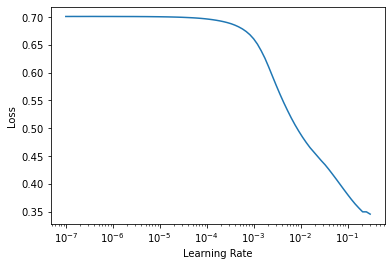

In [17]:
learn.lr_find()

# Fit Model

In [18]:
learn.fit_one_cycle(5,5e-3)

epoch,train_loss,valid_loss,time
0,0.223853,0.038717,00:00
1,0.087105,0.018329,00:00
2,0.046277,0.017615,00:00
3,0.030094,0.017208,00:00
4,0.022884,0.017151,00:00


In [19]:
#$mychange
#learn.save('model_fit1cylce_5epochs')

Path('models/model_fit1cylce_5epochs.pth')

In [21]:
learn.loss_func

FlattenedLoss of BCEWithLogitsLoss()

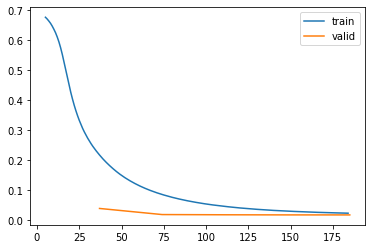

In [22]:
learn.recorder.plot_loss()

# Get Predictions for Submission
We follow the guide to setting up a test set here: https://forums.fast.ai/t/a-brief-guide-to-test-sets-in-v2-you-can-do-labelled-now-too/57054

In [23]:
test_dl = dls.test_dl(test_features)

In [24]:
test_dl.show(5)

,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,g-36,g-37,g-38,g-39,g-40,g-41,g-42,g-43,g-44,g-45,g-46,g-47,g-48,g-49,g-50,g-51,g-52,g-53,g-54,g-55,g-56,g-57,g-58,g-59,g-60,g-61,g-62,g-63,g-64,g-65,g-66,g-67,g-68,g-69,g-70,g-71,g-72,g-73,g-74,g-75,g-76,g-77,g-78,g-79,g-80,g-81,g-82,g-83,g-84,g-85,g-86,g-87,g-88,g-89,g-90,g-91,g-92,g-93,g-94,g-95,g-96,g-97,g-98,g-99,g-100,g-101,g-102,g-103,g-104,g-105,g-106,g-107,g-108,g-109,g-110,g-111,g-112,g-113,g-114,g-115,g-116,g-117,g-118,g-119,g-120,g-121,g-122,g-123,g-124,g-125,g-126,g-127,g-128,g-129,g-130,g-131,g-132,g-133,g-134,g-135,g-136,g-137,g-138,g-139,g-140,g-141,g-142,g-143,g-144,g-145,g-146,g-147,g-148,g-149,g-150,g-151,g-152,g-153,g-154,g-155,g-156,g-157,g-158,g-159,g-160,g-161,g-162,g-163,g-164,g-165,g-166,g-167,g-168,g-169,g-170,g-171,g-172,g-173,g-174,g-175,g-176,g-177,g-178,g-179,g-180,g-181,g-182,g-183,g-184,g-185,g-186,g-187,g-188,g-189,g-190,g-191,g-192,g-193,g-194,g-195,g-196,g-197,g-198,g-199,g-200,g-201,g-202,g-203,g-204,g-205,g-206,g-207,g-208,g-209,g-210,g-211,g-212,g-213,g-214,g-215,g-216,g-217,g-218,g-219,g-220,g-221,g-222,g-223,g-224,g-225,g-226,g-227,g-228,g-229,g-230,g-231,g-232,g-233,g-234,g-235,g-236,g-237,g-238,g-239,g-240,g-241,g-242,g-243,g-244,g-245,g-246,g-247,g-248,g-249,g-250,g-251,g-252,g-253,g-254,g-255,g-256,g-257,g-258,g-259,g-260,g-261,g-262,g-263,g-264,g-265,g-266,g-267,g-268,g-269,g-270,g-271,g-272,g-273,g-274,g-275,g-276,g-277,g-278,g-279,g-280,g-281,g-282,g-283,g-284,g-285,g-286,g-287,g-288,g-289,g-290,g-291,g-292,g-293,g-294,g-295,g-296,g-297,g-298,g-299,g-300,g-301,g-302,g-303,g-304,g-305,g-306,g-307,g-308,g-309,g-310,g-311,g-312,g-313,g-314,g-315,g-316,g-317,g-318,g-319,g-320,g-321,g-322,g-323,g-324,g-325,g-326,g-327,g-328,g-329,g-330,g-331,g-332,g-333,g-334,g-335,g-336,g-337,g-338,g-339,g-340,g-341,g-342,g-343,g-344,g-345,g-346,g-347,g-348,g-349,g-350,g-351,g-352,g-353,g-354,g-355,g-356,g-357,g-358,g-359,g-360,g-361,g-362,g-363,g-364,g-365,g-366,g-367,g-368,g-369,g-370,g-371,g-372,g-373,g-374,g-375,g-376,g-377,g-378,g-379,g-380,g-381,g-382,g-383,g-384,g-385,g-386,g-387,g-388,g-389,g-390,g-391,g-392,g-393,g-394,g-395,g-396,g-397,g-398,g-399,g-400,g-401,g-402,g-403,g-404,g-405,g-406,g-407,g-408,g-409,g-410,g-411,g-412,g-413,g-414,g-415,g-416,g-417,g-418,g-419,g-420,g-421,g-422,g-423,g-424,g-425,g-426,g-427,g-428,g-429,g-430,g-431,g-432,g-433,g-434,g-435,g-436,g-437,g-438,g-439,g-440,g-441,g-442,g-443,g-444,g-445,g-446,g-447,g-448,g-449,g-450,g-451,g-452,g-453,g-454,g-455,g-456,g-457,g-458,g-459,g-460,g-461,g-462,g-463,g-464,g-465,g-466,g-467,g-468,g-469,g-470,g-471,g-472,g-473,g-474,g-475,g-476,g-477,g-478,g-479,g-480,g-481,g-482,g-483,g-484,g-485,g-486,g-487,g-488,g-489,g-490,g-491,g-492,g-493,g-494,g-495,g-496,g-497,g-498,g-499,g-500,g-501,g-502,g-503,g-504,g-505,g-506,g-507,g-508,g-509,g-510,g-511,g-512,g-513,g-514,g-515,g-516,g-517,g-518,g-519,g-520,g-521,g-522,g-523,g-524,g-525,g-526,g-527,g-528,g-529,g-530,g-531,g-532,g-533,g-534,g-535,g-536,g-537,g-538,g-539,g-540,g-541,g-542,g-543,g-544,g-545,g-546,g-547,g-548,g-549,g-550,g-551,g-552,g-553,g-554,g-555,g-556,g-557,g-558,g-559,g-560,g-561,g-562,g-563,g-564,g-565,g-566,g-567,g-568,g-569,g-570,g-571,g-572,g-573,g-574,g-575,g-576,g-577,g-578,g-579,g-580,g-581,g-582,g-583,g-584,g-585,g-586,g-587,g-588,g-589,g-590,g-591,g-592,g-593,g-594,g-595,g-596,g-597,g-598,g-599,g-600,g-601,g-602,g-603,g-604,g-605,g-606,g-607,g-608,g-609,g-610,g-611,g-612,g-613,g-614,g-615,g-616,g-617,g-618,g-619,g-620,g-621,g-622,g-623,g-624,g-625,g-626,g-627,g-628,g-629,g-630,g-631,g-632,g-633,g-634,g-635,g-636,g-637,g-638,g-639,g-640,g-641,g-642,g-643,g-644,g-645,g-646,g-647,g-648,g-649,g-650,g-651,g-652,g-653,g-654,g-655,g-656,g-657,g-658,g-659,g-660,g-661,g-662,g-663,g-664,g-665,g-666,g-667,g-668,g-669,g-670,g-671,g-672,g-673,g-674,g-675,g-676,g-677,g-678,g-679,g-680

In [25]:
preds,_ = learn.get_preds(dl=test_dl)

In [26]:
preds.shape, preds.dtype

(torch.Size([3982, 206]), torch.float32)

In [27]:
preds_df = pd.DataFrame(preds).astype("float")

In [28]:
preds_df.head

<bound method NDFrame.head of                0             1         2         3         4         5    \
0     4.911050e-04  5.814648e-04  0.000544  0.008554  0.017697  0.002462   
1     4.873507e-04  5.520691e-04  0.001274  0.011498  0.005394  0.007583   
2     2.488593e-07  9.047078e-08  0.000002  0.001152  0.002324  0.000041   
3     4.990470e-04  5.955200e-04  0.002193  0.017823  0.009482  0.004617   
4     5.001361e-04  2.246334e-04  0.000854  0.009552  0.019008  0.001630   
...            ...           ...       ...       ...       ...       ...   
3977  9.845544e-05  1.261181e-04  0.000144  0.004650  0.006845  0.000711   
3978  6.353828e-04  4.787484e-04  0.000842  0.004965  0.016541  0.002152   
3979  2.319919e-04  2.067792e-04  0.000517  0.004817  0.020851  0.006116   
3980  8.342246e-04  2.932574e-04  0.000867  0.011773  0.024869  0.003604   
3981  6.205885e-04  8.014418e-04  0.001133  0.011954  0.022814  0.005991   

           6         7             8         9    ...    

In [29]:
submission = sub
submission[dep_var] = preds_df
submission.loc[test_features['cp_type']=='ctl_vehicle', dep_var] = 0

In [30]:
submission.head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_0004d9e33,0.000491,0.000581,0.000544,0.008554,0.017697,0.002462,0.002393,0.003841,0.000396,...,0.000094,0.000476,0.001775,0.001278,0.001193,0.000191,0.002290,0.000801,0.000910,0.001072
1,id_001897cda,0.000487,0.000552,0.001274,0.011498,0.005394,0.007583,0.001952,0.008669,0.001841,...,0.001014,0.003960,0.005328,0.010447,0.032456,0.000214,0.028646,0.001108,0.003551,0.001330
2,id_002429b5b,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,id_00276f245,0.000499,0.000596,0.002193,0.017823,0.009482,0.004617,0.002214,0.005237,0.002012,...,0.000713,0.001004,0.006676,0.042389,0.007631,0.000219,0.022608,0.002346,0.005442,0.001477
4,id_0027f1083,0.000500,0.000225,0.000854,0.009552,0.019008,0.001630,0.002637,0.003748,0.000357,...,0.000172,0.000397,0.001465,0.000716,0.000726,0.000434,0.001059,0.001207,0.002536,0.000992


In [31]:
submission.to_csv('submission.csv', index=False)